# EDA

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

applications = pd.read_csv("../data/processed/cleaned_applications.csv") 
records = pd.read_csv("../data/processed/cleaned_records.csv")

ModuleNotFoundError: No module named 'seaborn'

## 1. Identifying Categorical and Numerical Variables

In [9]:
numerical_features = applications.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_features

['id',
 'num_children',
 'annual_income',
 'days_birth',
 'days_employed',
 'work_phone',
 'phone',
 'email',
 'family_size']

In [10]:
categorical_features = applications.select_dtypes(include=['object']).columns.tolist()

categorical_features

['gender',
 'own_car',
 'own_realty',
 'income_type',
 'education_type',
 'family_status',
 'housing_type',
 'occupation']

## 2. Histograms for Numerical Features


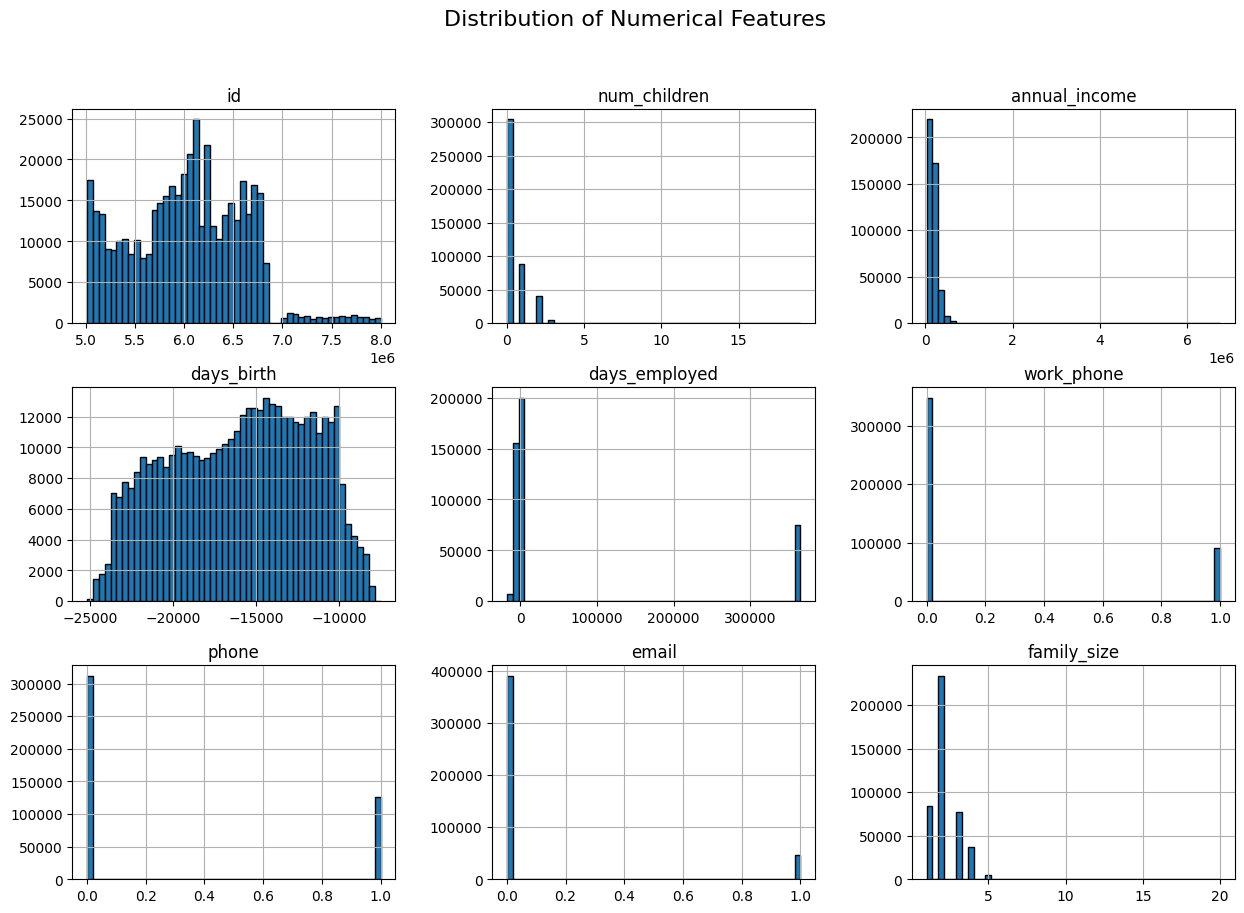

In [ ]:
applications[numerical_features].hist(figsize = (15, 10), bins = 50, edgecolor = 'black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

## 3. Plot Barcharts

Barcharts for the distribution of categorical features for class imbalances (Cross check with eda step 7?)

tbh not sure if this is very needed - feels like more for show?


## 4. Correlation Heatmaps

For seeing relationship between features and identifying highly correlated features

In [ ]:


correlation_matrix = applications[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

## 5. Remove Redundancy
- Remove highly correlated features to avoid multicollinearity.
- We observe that num_children and family_size are strongly correlated at 0.88
- We will drop num_children since family_size includes num_children



In [10]:
applications.drop(columns=['num_children'], inplace=True)

# Feature Engineering

## Convert to readable format
- Process days_birth to age and days_employed to years_employed


In [11]:
applications['age'] = (-applications['days_birth']) // 365
applications = applications.drop('days_birth', axis=1)

applications['years_employed'] = -applications['days_employed'].apply(lambda x: x / 365 if x < 0 else -1)
applications = applications.drop('days_employed', axis=1)

applications.head()

,id,gender,own_car,own_realty,annual_income,income_type,education_type,family_status,housing_type,mobile,work_phone,phone,email,occupation,family_size,age,years_employed
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,32,12.443836
1,5008805,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,32,12.443836
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,58,3.106849
3,5008808,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.358904
4,5008809,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52,8.358904


## One-Hot Encoding Categorical Variables
- Apply **one-hot encoding** to convert them into numerical format.
- For binary make it 0 and 1


In [12]:
#for own_car column
applications['own_car'] = applications['own_car'].replace({"Y":1, "N":0})

#for own_realty
applications['own_realty'] = applications['own_realty'].replace({"Y":1, "N":0})

#for gender
applications['gender'] = applications['gender'].replace({"M":1, "F":0})


C:\Users\ashle\AppData\Local\Temp\ipykernel_23224\1898058483.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  applications['own_car'] = applications['own_car'].replace({"Y":1, "N":0})
C:\Users\ashle\AppData\Local\Temp\ipykernel_23224\1898058483.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  applications['own_realty'] = applications['own_realty'].replace({"Y":1, "N":0})
C:\Users\ashle\AppData\Local\Temp\ipykernel_23224\1898058483.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a f

In [13]:
# Identify categorical variables
#categorical_cols = ["income_type", "education_type", "family_status", "housing_type", "occupation"]

# Perform One-Hot Encoding
# applications = pd.get_dummies(applications, columns=categorical_cols, drop_first=True)

# Display the first few rows
#applications.head()

In [14]:
unique_income_type = applications["income_type"].unique()
print(unique_income_type)

unique_education = applications["education_type"].unique()
print(unique_education)

unique_family = applications["family_status"].unique()
print(unique_family)

unique_housing = applications["housing_type"].unique()
print(unique_housing)

unique_occupations = applications["occupation"].unique()
print(unique_occupations)

print(applications.columns.tolist())

['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']
['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
['Others' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']
['id', 'gender', 'own_car', 'own_realty', 'annual_income', 'income_type', 'education_type', 'family_status', 'housing_type', 'mobile', 'work_phone', 'phone', 'email', 'occupation', 'family_size', 'age', 'years_employed']


## Scaling Continuous Features
Continuous numerical variables have different scales
- e.g. age is between 0-100, income can be in the thousands or millions

So we normalise values between 0 and 1 (min-max scaling)


In [15]:
from sklearn.preprocessing import MinMaxScaler

# Select continuous features to scale
continuous_features = ['annual_income', 'age', 'years_employed']

# Initialize MinMaxScaler (scales values between 0 and 1)
scaler = MinMaxScaler()

# Apply scaling
applications[continuous_features] = scaler.fit_transform(applications[continuous_features])

# Display the first few rows
applications.head()


,id,gender,own_car,own_realty,annual_income,income_type,education_type,family_status,housing_type,mobile,work_phone,phone,email,occupation,family_size,age,years_employed
0,5008804,1,1,1,0.059697,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,0.244898,0.258576
1,5008805,1,1,1,0.059697,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,0.244898,0.258576
2,5008806,1,1,1,0.012850,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0.775510,0.064045
3,5008808,0,0,1,0.036274,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.653061,0.173469
4,5008809,0,0,1,0.036274,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.653061,0.173469


## Flatten the status dataset
Convert status to numeric and weight them based on lateness

In [ ]:
status_mapping = {
    "0": 1,  
    "1": 2, 
    "2": 3,  
    "3": 4, 
    "4": 5,  
    "5": 6,  
}
# "C" and "X" will be summarised separately 

records["status_numeric"] = records["status"].map(status_mapping)

def sum_of_status(record):
    total_paid = (record['status'] == 'C').sum() #paid on time
    total_no_loans = (record['status'] == 'X').sum() #no loans
    sum_months_late = record['status_numeric'].dropna().sum()

    return pd.Series({
        'total_paid': total_paid,
        'total_no_loans': total_no_loans,
        'sum_months_late': sum_months_late #sum late payment months
    })

user_status_summary = records.groupby("id").apply(sum_of_status).reset_index()

# Scale the different statuses (paid/no loans/months late)


# final_counts = records.merge(user_status_summary, on='id', how='left')
# final_counts.drop(columns= ["status_numeric","status"])

# aggregate to find the worst status per user
#user_worst_status = records.groupby("id")["status_numeric"].max().reset_index()



# good bad labels
#user_worst_status["credit_label"] = user_worst_status["status_numeric"].apply(lambda x: 1 if x >= 2 else 0)


#user_worst_status = user_worst_status.drop(columns=["status_numeric"])

# merge
# applications = applications.merge(final_counts, on="id", how="left")

#counts.head()
# applications.head()
#final_counts.head()

## Apply Kmeans Clustering
Scale the different statuses (paid/no loans/months late)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

kmeans_features = user_status_summary[["total_paid", "total_no_loans", "sum_months_late"]]

scaler = StandardScaler() #standardization
scaled_features = scaler.fit_transform(kmeans_features)

kmeans = KMeans(n_clusters=2, random_state=42)
user_status_summary["credit_label"] = kmeans.fit_predict(scaled_features)

# view the average behavior of each cluster ( good(0) + bad(1) )
user_status_summary.groupby("credit_label")[["total_paid", "total_no_loans", "sum_months_late"]].mean()


,total_paid,total_no_loans,sum_months_late
credit_label,,,
0,2.431556,5.797014,9.477530
1,29.731151,1.056134,8.207093


In [ ]:
print("Applications rows:", len(applications))
print("Unique application IDs:", applications["id"].nunique())
print("user status summary rows:", len(user_status_summary))

Applications rows: 438510
Unique application IDs: 438510
user status summary rows: 45985


## Merge the datasets
Combine the records dataset which now includes the target label with the application dataset with the features


In [ ]:
applications_clean = applications.drop_duplicates(subset="id")

applications_merged = applications_clean.merge(
    user_status_summary[["id", "credit_label"]], #Do we want to include the other columns
    on="id",
    how="left")
applications_merged = applications_merged.dropna(subset=["credit_label"]) #drop NaN labelled rows

applications_merged.head()


,id,gender,own_car,own_realty,annual_income,income_type,education_type,family_status,housing_type,mobile,work_phone,phone,email,occupation,family_size,age,years_employed,credit_label
0,5008804,1,1,1,0.059697,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,0.254968,0.258576,0.0
1,5008805,1,1,1,0.059697,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Others,2.0,0.254968,0.258576,0.0
2,5008806,1,1,1,0.012850,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0.789578,0.064045,0.0
3,5008808,0,0,1,0.036274,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.656109,0.173469,0.0
4,5008809,0,0,1,0.036274,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.656109,0.173469,0.0


In [ ]:
len(applications_merged)

applications_merged.to_csv("../data/processed/merged_data.csv", index=False)